In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10683.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10736.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10489.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10512.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10975.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10064.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10281.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10384.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10986.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10870.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10786.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10268.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10760.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10759.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_11008

In [5]:
import os
import numpy  as np 
import warnings
warnings.filterwarnings("ignore")

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-12 19:12:40.706296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 19:12:40.706386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 19:12:40.808599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


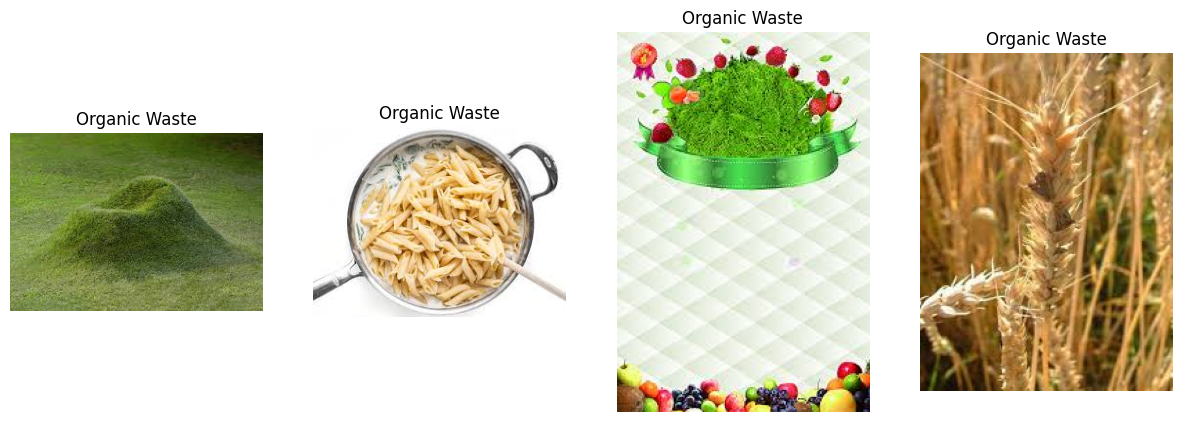

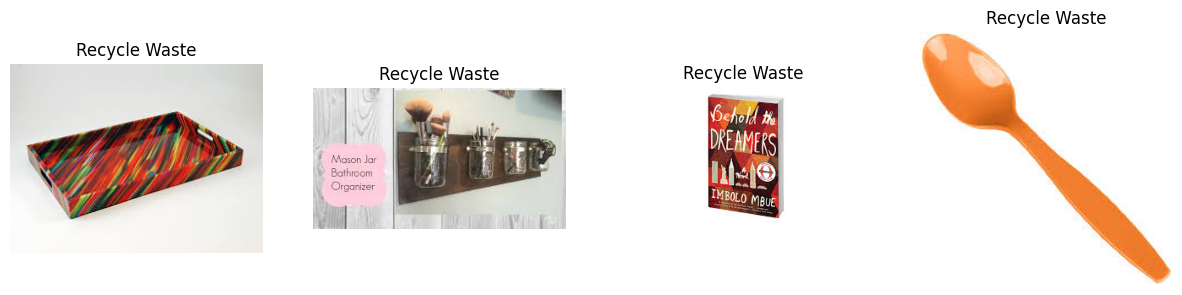

In [6]:
def plot_random_images(dataset_dir, category, num_images=4):
    # Path to the specified category directory
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    
    # Get the list of image file names in the category directory
    image_files = os.listdir(category_dir)
    
    # Select num_images random images from the category directory
    random_images = random.sample(image_files, num_images)
    
    # Plot the random images
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(random_images):
        # Load the image
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        
        # Plot the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")  # Set the title for each image
        plt.axis('off')
    
    plt.show()

# Example usage: plot 4 random images from 'O' (Organic) and 'R' (Recyclable) categories
dataset_dir = '/kaggle/input/waste-classification-data/DATASET'
plot_random_images(dataset_dir, 'O', num_images=4)
plot_random_images(dataset_dir, 'R', num_images=4)

In [7]:
train_directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN'
test_directory = '/kaggle/input/waste-classification-data/DATASET/TEST'

In [8]:
train_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

validation_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

test_data_generator = ImageDataGenerator(
    #rescale = 1./255,
    preprocessing_function=preprocess_input
)

In [9]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="training",
    seed = 43
)
validation_generator = validation_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="validation",
    seed = 43
)
test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True
)


Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [10]:
# Define the core VGG16 model with pre-trained weights
core = VGG16(include_top=False, weights='/kaggle/input/vgg16-weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=(150, 150, 3))
core.trainable = False

# Define the sequential model
model = Sequential([
    core,
    Flatten(),
    Dense(100, activation="relu"),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Define early stopping callback
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# Define model checkpoint callback based on validation accuracy
checkpoint_path = "model_checkpoint.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_generator, epochs=8, validation_data=validation_generator, callbacks=[earlystopping, checkpoint])


Epoch 1/8


I0000 00:00:1715541246.347995     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715541246.367504     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/142 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8064 - loss: 1.0702

W0000 00:00:1715541420.243325     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8092 - loss: 1.0412

W0000 00:00:1715541424.807306     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715541460.228501     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.91910, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.8095 - loss: 1.0381 - val_accuracy: 0.9191 - val_loss: 0.2235
Epoch 2/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.8960 - loss: 0.2841
Epoch 2: val_accuracy improved from 0.91910 to 0.92908, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 954ms/step - accuracy: 0.8960 - loss: 0.2841 - val_accuracy: 0.9291 - val_loss: 0.2042
Epoch 3/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9115 - loss: 0.2307
Epoch 3: val_accuracy did not improve from 0.92908
142/142 ━━━━━━━━━━━━━━━━━━━━ 141s 948ms/step - accuracy: 0.9115 - loss: 0.2308 - val_accuracy: 0.9193 - val_loss: 0.2566
Epoch 4/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9177 - loss: 0.2277
Epoch 4: val_accuracy did not improve from 0.92908
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 954ms/step - accuracy: 0.9176 - loss: 0.2277 - val_accu

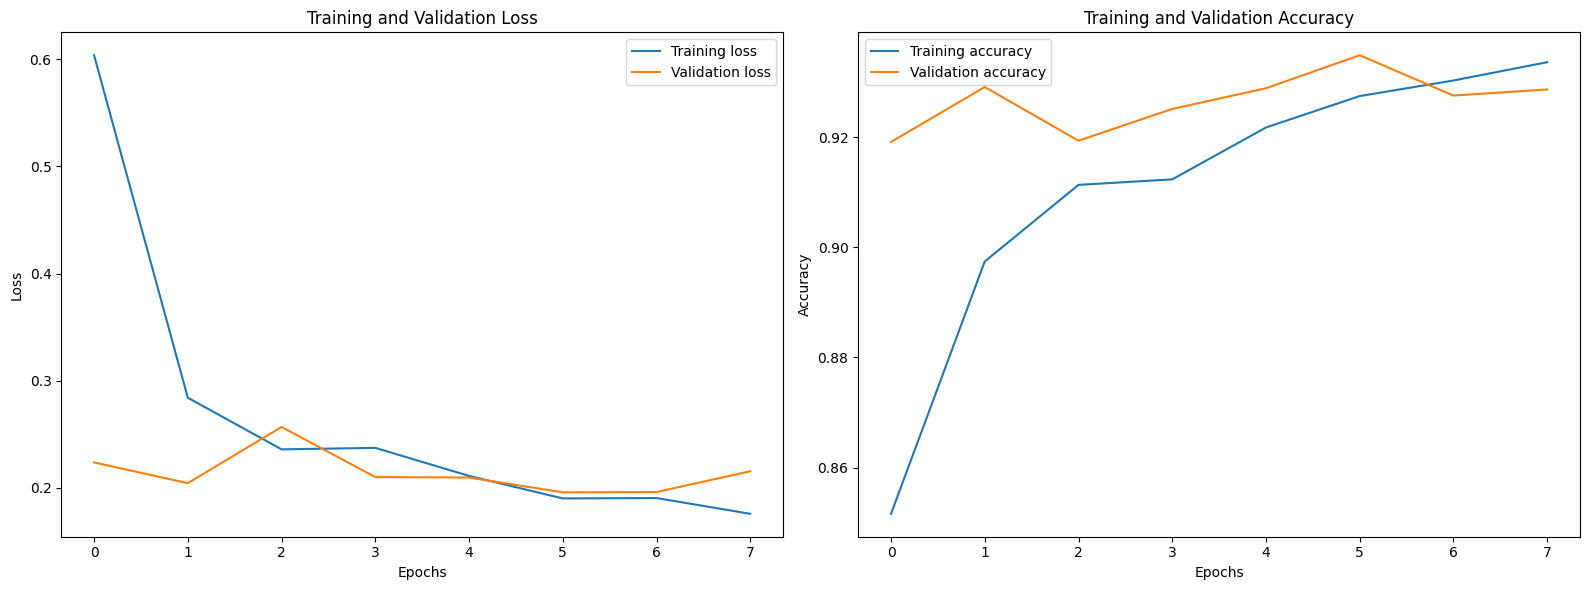

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(12, 5)):
    """
    Plot training and validation metrics over epochs.

    Parameters:
        history (History): History object returned by model.fit().
        metrics (list): List of metrics to plot (e.g., ['loss', 'accuracy']).
        figsize (tuple): Figure size (width, height) in inches.

    Returns:
        None
    """
    # Create subplots based on the number of metrics
    num_metrics = len(metrics)
    plt.figure(figsize=figsize)
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, i)
        plt.plot(history.epoch, history.history[metric], label='Training ' + metric)
        plt.plot(history.epoch, history.history['val_' + metric], label='Validation ' + metric)
        plt.title('Training and Validation ' + metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'history' contains the training history object
plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(16, 6))

In [12]:
evaluation = model.evaluate(test_generator)
print(f'test Loss: {evaluation[0]:.4f}')
print(f'test Accuracy: {evaluation[1] * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8894 - loss: 0.3687 
test Loss: 0.3607
test Accuracy: 89.22%


W0000 00:00:1715542509.721553     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# **CNN is used here **


In [18]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob


In [22]:
import cv2
from tqdm import tqdm  # Import tqdm for progress tracking
import pandas as pd
from glob import glob

train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"
x_data = [] 
y_data = [] 
for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 12565/12565 [00:33<00:00, 379.19it/s]


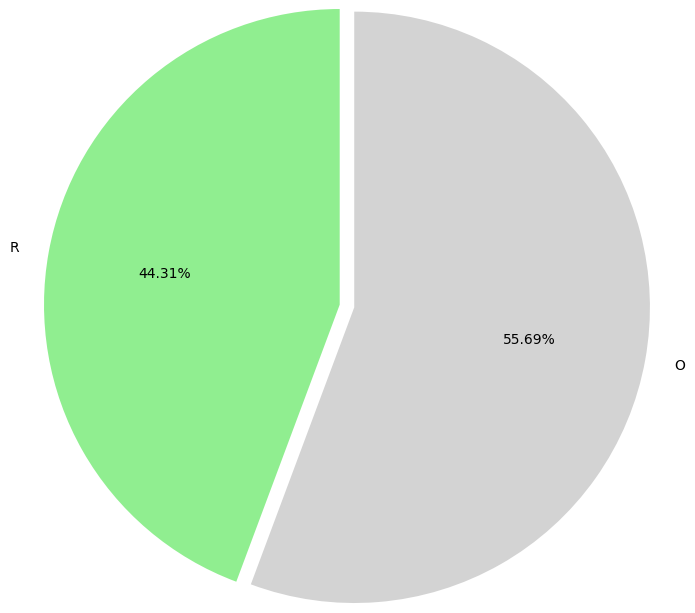

In [25]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each label in y_data
label_counts = Counter(y_data)

# Define colors for the pie chart
colors = ['lightgreen', 'lightgrey']  # Specify color names or use RGB values directly

# Plot the pie chart
plt.pie(label_counts.values(), startangle=90, explode=[0.05, 0.05], autopct='%0.2f%%',
        labels=label_counts.keys(), colors=colors, radius=2)

# Display the pie chart
plt.show()

Num GPUs Available:  2
Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Epoch 1/8


W0000 00:00:1715545121.264930     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.6979 - loss: 0.8573

W0000 00:00:1715545185.717537     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


89/89 ━━━━━━━━━━━━━━━━━━━━ 143s 995ms/step - accuracy: 0.6988 - loss: 0.8541 - val_accuracy: 0.8727 - val_loss: 0.3708
Epoch 2/8


W0000 00:00:1715545209.116563     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - accuracy: 0.8280 - loss: 0.4116 - val_accuracy: 0.8934 - val_loss: 0.3243
Epoch 3/8
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 631ms/step - accuracy: 0.8491 - loss: 0.3746 - val_accuracy: 0.8882 - val_loss: 0.2963
Epoch 4/8
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 642ms/step - accuracy: 0.8623 - loss: 0.3416 - val_accuracy: 0.8747 - val_loss: 0.2981
Epoch 5/8
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 637ms/step - accuracy: 0.8692 - loss: 0.3251 - val_accuracy: 0.8882 - val_loss: 0.2907
Epoch 6/8
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 633ms/step - accuracy: 0.8843 - loss: 0.2876 - val_accuracy: 0.8989 - val_loss: 0.2824
Epoch 7/8
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - accuracy: 0.8944 - loss: 0.2603 - val_accuracy: 0.9033 - val_loss: 0.2596
Epoch 8/8
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 630ms/step - accuracy: 0.9143 - loss: 0.2246 - val_accuracy: 0.8969 - val_loss: 0.3160


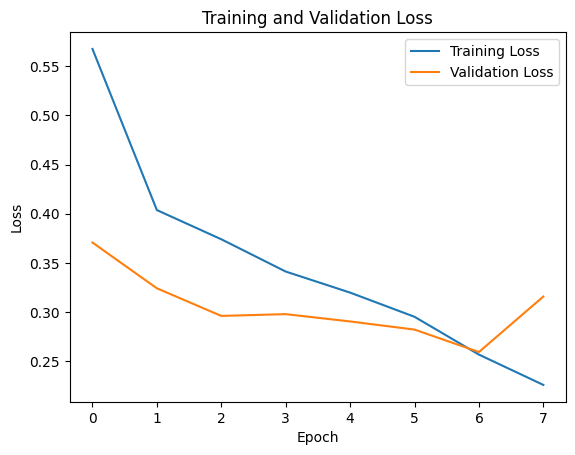

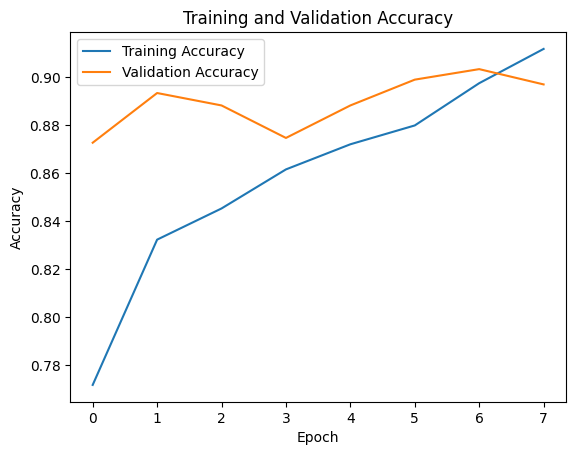

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 584ms/step - accuracy: 0.8948 - loss: 0.3202
Overall Accuracy: 0.8969359397888184
 1/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

W0000 00:00:1715545644.162327     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step
Class O: Accuracy = 0.63
Class R: Accuracy = 0.37


W0000 00:00:1715545649.296604     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define the number of classes
numberOfClass = 2  # Replace with the actual number of classes in your dataset

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass, activation="softmax"))  # Output layer with softmax activation for multi-class classification

model.compile(loss="categorical_crossentropy",  # Use categorical crossentropy for multi-class classification
              optimizer="adam",
              metrics=["accuracy"])

# Set up data generators
batch_size = 256
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

# Train the model and collect history
history = model.fit(
    train_generator,
    epochs=8,
    validation_data=test_generator
)

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate model
results = model.evaluate(test_generator)
print("Overall Accuracy:", results[1])

# Print class-wise accuracy
class_labels = list(test_generator.class_indices.keys())
class_wise_results = model.predict(test_generator)
for i, class_label in enumerate(class_labels):
    class_accuracy = class_wise_results[:, i].mean()
    print("Class {}: Accuracy = {:.2f}".format(class_label, class_accuracy))
